# From XML to CSV

In [129]:
import os
import xmltodict
import pandas as pd
import matplotlib.pyplot as plt
from community import community_louvain
import networkx as nx
from netgraph import Graph
import numpy as np
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '.')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '.')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

df_list = []
for file in os.listdir("../re3data/repo_md/"):
    json_doc = xmltodict.parse(open("../re3data/repo_md/"+file,"r").read())

    # Driver code
    dictio=flatten_json(json_doc)
    # open("test.json","w").write(json.dumps(flatten_json(json_doc), indent=4))
    df_list.append(pd.DataFrame.from_dict(dictio, orient="index").transpose())



data_df = pd.concat(df_list)
data_df.to_csv("results_repository_MD.csv", index=False)


# Data selection

In [130]:
data_selection = data_df.filter(regex="repositoryName.*text|repositoryIdentifier|subject.*text|apiType|keyword|metadataStandardName.*text")
data_selection.to_csv("data_selection.csv", index=False)


# Data cleaning

In [131]:
keywords = data_selection.filter(regex="keyword").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
subject = data_selection.filter(regex="subject.*text").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
API = data_selection.filter(regex="apiType").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
MD_standards = data_selection.filter(regex="metadataStandardName.*text").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
id = data_selection.filter(regex="repositoryIdentifier").transpose().apply(lambda x : '#'.join(x.dropna().astype(str)))
name = data_selection.filter(regex="repositoryName.*text")


cleaned_df = pd.concat([name,id,subject,keywords,API, MD_standards],axis=1)
column_name = ["name","id","subject","keywords","API_type","MD_standards"]
rename_dict = {}
for old_name,new_name in zip(cleaned_df.columns,column_name):
    rename_dict[old_name]=new_name
# print(rename_dict)
cleaned_df = cleaned_df.rename(rename_dict,axis=1)
cleaned_df.to_csv("data_selection_cleaned.csv", index=False)



# Edges creation

In [132]:
repo_data = cleaned_df

repo_no_na = repo_data.dropna(subset=["API_type","MD_standards"])

# List of platform that implements API then MD_standards
# Any platform in a same list is interoperable with other
node_edges = {}


unique_api_type = set(repo_no_na["API_type"].map(lambda x : x.split("#")).sum())
unique_api_type.remove('')
for API in unique_api_type:
    print(API)
    node_edges[API] = {}

    unique_MD = set(repo_no_na[repo_no_na["API_type"].map(lambda x : API in x)]["MD_standards"].map(lambda x : x.split("#")).sum())
    for MD in unique_MD:

        node_edges[API][MD]=list(pd.merge(repo_no_na[repo_no_na["MD_standards"].map(lambda x: x.split("#")).map(lambda x : bool(len(set(x).intersection(set([MD])))>0 ))],repo_no_na[repo_no_na["API_type"].map(lambda x : x.split("#")).map(lambda x : bool(set(x) & set([API])) )])["name"])


REST
FTP
OpenDAP
SPARQL
SWORD
OAI-PMH
NetCDF
other
SOAP


In [133]:
node_edges.keys()

dict_keys(['REST', 'FTP', 'OpenDAP', 'SPARQL', 'SWORD', 'OAI-PMH', 'NetCDF', 'other', 'SOAP'])

# Every edges - every nodes - every protocol : Interoperability of platforms

In [134]:
from itertools import combinations
import random
couple_node_data_analysis = []

for API in node_edges:
    for MD in node_edges[API]:
        # if MD != "Dublin Core":
            couple_node_data_analysis += list(set([tuple(sorted(x)) for x in combinations(node_edges[API][MD],2)]))
        # for i in range(len(node_edges[API][MD])):
        #     couple_node.append((node_edges[API][MD][i], node_edges[API][MD][(i+1)%len(node_edges[API][MD])]))
        #     couple_node.append((node_edges[API][MD][i], node_edges[API][MD][(i+5)%len(node_edges[API][MD])] ))
            # Exchange uncommented line with this one to get every edges
            # couple_node.append((MD+"-OAI-PMH",node_edges["OAI-PMH"][MD][i]))


In [135]:
len(couple_node_data_analysis)

156455

In [136]:
node_edges

{'REST': {'': ['PSnpBind',
   'Hazardous Substance Data Bank',
   'Saccharomyces Genome Database',
   'immuneACCESS',
   'Allen Brain Atlas',
   'UniSave',
   'The World Bank Open Data',
   'ChEMBL',
   'Climate Data Online',
   'InGeoCloudS',
   'Haldimand County Open Data',
   'Open Government Data Platform India',
   'International Mouse Phenotyping Consortium',
   'OECD iLibrary Statistics',
   "City of Abbotsford's Open Data Hub",
   'Open Government Data Portal of Odisha',
   'Complex Portal',
   'Whitby GeoHub',
   'Edmonton Open Data',
   'prometheus',
   'Datanator',
   'U.S. Department of Labor, Bureau of Labor Statistics',
   'ZINC',
   'Open Energy Platform',
   'virus mentha',
   'ABCD Data Repository',
   'Expression Atlas',
   'Harmonia Universalis',
   'WormBase',
   'PharmGKB',
   'DrugBank',
   'Thunder Bay Open Data Portal',
   'NF Data Portal',
   'Water Quality Portal',
   'Global Forest Change',
   'NASC',
   'Maple Ridge Open Government Portal',
   'Academic Torr

In [137]:

G = nx.Graph()

# import igraph as ig
G.add_nodes_from(list(repo_data["name"].values))
for i in [MD for MD in node_edges["OAI-PMH"]]:
    G.add_node(i, color="green")
G.add_edges_from(couple_node_data_analysis)

In [138]:
print(str(len(G.nodes)) + " nodes / " + str(len(G.edges)) + " edges")
print("Duplicate edges are merged in an unique edge")

3140 nodes / 133654 edges
Duplicate edges are merged in an unique edge


## Density of the graph : all nodes all edges

In [139]:
nx.density(G)

0.027120081652033286

## Mean degree in the graph : all nodes all edges

In [140]:
np.mean([d for _, d in G.degree()])

85.12993630573249

<Axes: ylabel='Frequency'>

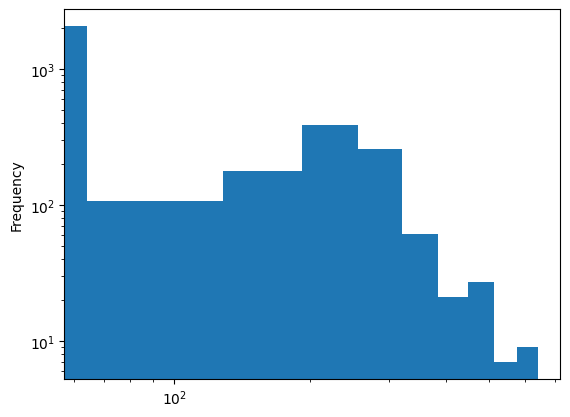

In [141]:
import matplotlib.pyplot as plt

# plt.hist(pd.Series([d for _, d in G.degree()]), log=True)

pd.Series([d for _, d in G.degree()]).plot(kind="hist", logx=True, logy=True)


## Removing unconnected nodes

In [142]:
isolated_nodes = list(nx.isolates(G))
print(len(isolated_nodes))

1731


In [143]:
G.remove_nodes_from(isolated_nodes)


In [144]:
print(str(len(G.nodes)) + " nodes / " + str(len(G.edges)) + " edges")


1409 nodes / 133654 edges


# Density without isolated nodes

In [145]:
nx.density(G)

0.13474054777727595

# Mean degree without isolated nodes

In [146]:
np.mean([d for _, d in G.degree()])

189.71469127040453

# Selecting data only on OAI-PMH : Knowledge sharing in Open Science

In [147]:
from itertools import combinations
import random
couple_node = []

# for API in node_edges:
for MD in node_edges["OAI-PMH"]:
    # if MD != "Dublin Core":
        couple_node += list(set([tuple(sorted(x)) for x in combinations(node_edges["OAI-PMH"][MD],2)]))
    # for i in range(len(node_edges["OAI-PMH"][MD])):
        # couple_node.append((node_edges["OAI-PMH"][MD][i], node_edges["OAI-PMH"][MD][(i+1)%len(node_edges["OAI-PMH"][MD])]))
        # couple_node.append((node_edges["OAI-PMH"][MD][i], node_edges["OAI-PMH"][MD][(i+5)%len(node_edges["OAI-PMH"][MD])] ))
        # Exchange uncommented line with this one to get every edges
        # couple_node.append((MD+"-OAI-PMH",node_edges["OAI-PMH"][MD][i]))


# Graph creation : only on OAI-PMH

In [148]:

G_OAI = nx.Graph()

# import igraph as ig
G_OAI.add_nodes_from(list(repo_data["name"].values))
# Change color of node for OAI-PMH
for i in [MD+"-OAI-PMH" for MD in node_edges["OAI-PMH"]]:
    G.add_node(i, color="green")
G_OAI.add_edges_from(couple_node)

In [149]:
print(str(len(G_OAI.nodes)) + " nodes / " + str(len(G_OAI.edges)) + " edges")


3116 nodes / 22179 edges


# Graph density : only on OAI-PMH (knowledge sharing)

In [150]:
nx.density(G_OAI)

0.004570002699266665

# Mean degree :  only on OAI-PMH (knowledge sharing)

In [151]:
np.mean([d for _, d in G_OAI.degree()])

14.235558408215661

# Check if follow a power law

            0
count        
0.016748    0
0.004885    1
0.000698    2
0.002094    3
0.002791    4
...       ...
0.002791  522
0.000698  525
0.000698  526
0.005583  626
0.000698  641

[201 rows x 1 columns]


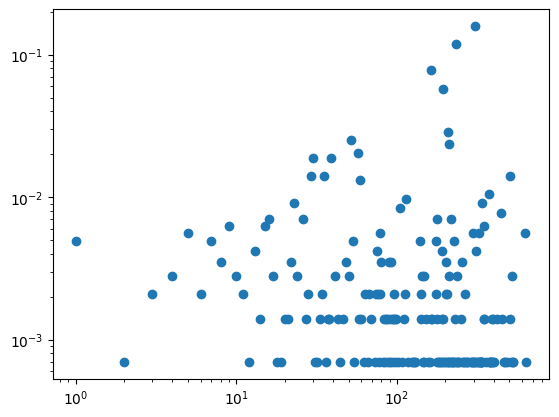

In [246]:
import powerlaw


data = sorted([d for _, d in G.degree()])
data = pd.Series(data)
prob_degree = data.value_counts()/len(data)
plot_df = pd.DataFrame(data.unique(),index=prob_degree.sort_index())
print(plot_df)
# results = powerlaw.Fit(data)
# print(results.power_law.alpha)
# print(results.power_law.xmin)
# R, p = results.distribution_compare("power_law","lognormal")
#
plt.yscale("log")
plt.xscale("log")
plt.scatter(y=plot_df.index, x=plot_df)
#
#
# print(prob_degree.sort_index())
# print(data.unique())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


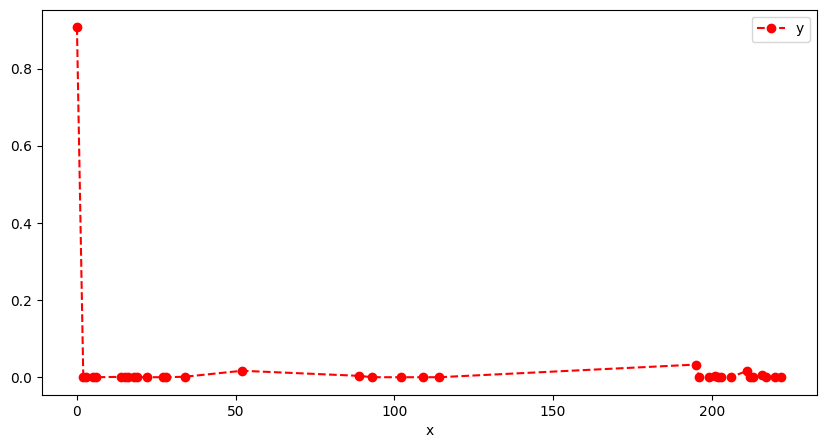

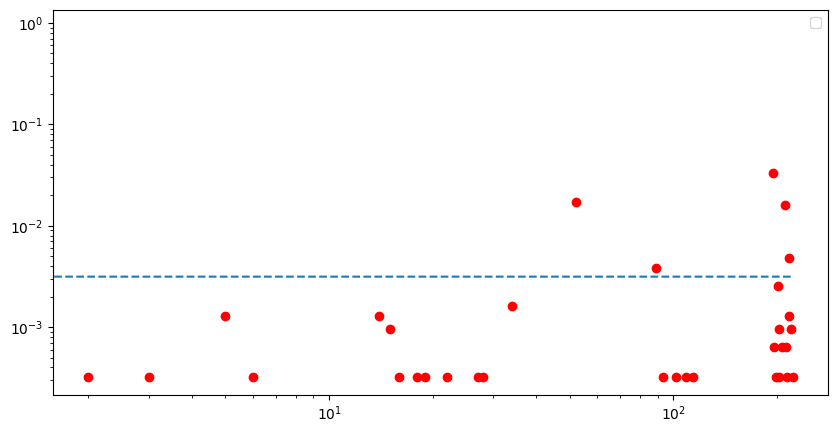

In [225]:



%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
data = sorted([d for _, d in G_OAI.degree()])
data = pd.Series(data)
prob_degree = data.value_counts()/len(data)

df = pd.DataFrame({
            'x': data.unique(),
            'y': prob_degree.sort_index()
        })
df.plot(x='x', y='y', kind='line', style='--ro', figsize=(10, 5))

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

target_func = func_powerlaw

X = df['x']
y = df['y']

popt, pcov = curve_fit(target_func, X, y)

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--')
plt.plot(X, y, 'ro')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()



x = np.asarray([ 1000, 3250, 5500, 10000, 32500, 55000, 77500, 100000, 200000 ])
y = np.asarray([ 1100, 500, 288, 200, 113, 67, 52, 44, 5 ])

sol1 = curve_fit(func_powerlaw, x, y, maxfev=2000 )
sol2 = curve_fit(func_powerlaw, x, y, p0 = np.asarray([-1,10**5,0]))




## Removing isolated nodes : only on OAI-PMH (knowledge sharing)

In [117]:
isolated_nodes = list(nx.isolates(G_OAI))
print(len(isolated_nodes))

0


In [110]:
G_OAI.remove_nodes_from(isolated_nodes)
print(str(len(G_OAI.nodes)) + " nodes / " + str(len(G_OAI.edges)) + " edges")


290 nodes / 22179 edges


# Graph density without isolated nodes

In [113]:
nx.density(G_OAI)

0.529268583701229

# Mean degree without isolated nodes

In [121]:
np.mean([d for _, d in G_OAI.degree()])

152.95862068965516

# Degree distribution

<Axes: >

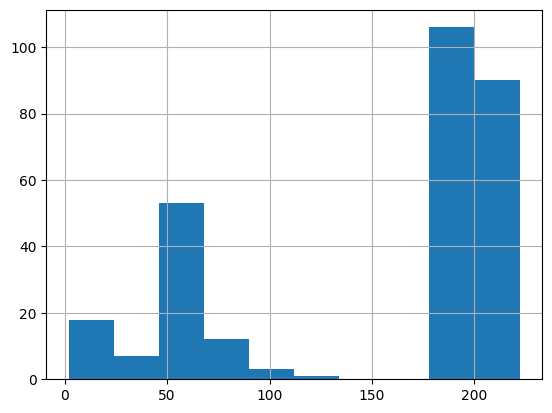

In [123]:


pd.Series([d for _, d in G_OAI.degree()]).hist()

# Data viz
## Selecting 2 edge

In [ ]:
from itertools import combinations
import random
couple_node = []

for API in node_edges:
    for MD in node_edges[API]:
        # if MD != "Dublin Core":
        #     couple_node += list(set([tuple(sorted(x)) for x in combinations(node_edges[API][MD],2)]))
        for i in range(len(node_edges[API][MD])):
            couple_node.append((node_edges[API][MD][i], node_edges[API][MD][(i+1)%len(node_edges[API][MD])]))
            couple_node.append((node_edges[API][MD][i], node_edges[API][MD][(i+5)%len(node_edges[API][MD])] ))
            # Exchange uncommented line with this one to get every edges
            # couple_node.append((MD+"-OAI-PMH",node_edges["OAI-PMH"][MD][i]))


## Plotting

In [110]:

G = nx.Graph()

# import igraph as ig
G.add_nodes_from(list(repo_data["name"].values))
for i in [MD+"-OAI-PMH" for MD in node_edges["OAI-PMH"]]:
    G.add_node(i, color="green")
G.add_edges_from(couple_node)
# result_df = pd.read_csv("data_selection.csv")
# for repo in result_df.iloc:
#     g_2.add_vertex(repo["name"], color="blue")
# g_3.add_vertices(list(repo_data["name"].values))
# for i in [MD+"-OAI-PMH" for MD in node_edges["OAI-PMH"]]:
#     g_3.add_vertex(i)
# g_3.add_edges(couple_node)

print(nx.density(G))
# installation easiest via pip:
# pip install netgraph
fig = plt.figure(figsize=(18,18))
# create a modular graph
partition_sizes = [10, 20, 30, 40]
# g = nx.random_partition_graph(partition_sizes, 0.5, 0.1)
g=G
# since we created the graph, we know the best partition:
# node_to_community = dict()
# node = 0
# for community_id, size in enumerate(partition_sizes):
#     for _ in range(size):
#         node_to_community[node] = community_id
#         node += 1
node_to_community = community_louvain.best_partition(G)

# # alternatively, we can infer the best partition using Louvain:
# from community import community_louvain
# node_to_community = community_louvain.best_partition(g)
res = {}
for i in node_to_community:
    if node_to_community[i] in res :
        res[node_to_community[i]] += 1
    else:
        res[node_to_community[i]] = 1

communities_unique = []
for key in res :
    if res[key]!=1:
        communities_unique.append(key)


for i in node_to_community:
    if node_to_community[i] not in communities_unique:
        node_to_community[i]=7

# node_to_community
# print(communities_unique)

community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:brown',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:olive',
    9 : 'tab:cyan'
}
aux = {key : index for index,key in enumerate(communities_unique) }
node_color = { node :(community_to_color[aux[community_id]] if community_id in communities_unique else community_to_color[7]) for node, community_id in node_to_community.items() }
# node_color = {node:    }

#
Graph(g,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
        node_layout="community", node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', node_size=0.3
)
plt.savefig("community_allnode.pdf")
plt.show()

In [262]:
df_vol = pd.read_csv("results_repository_MD.csv",header=0, low_memory=False)["r3d:re3data.r3d:repository.r3d:size.#text"].dropna()

df_vol[df_vol.map(lambda x : "dataset" in x )]

2                               641 results; 509 datasets
6                                              3 datasets
10                                         1.428 datasets
11                                         1.246 datasets
20               19 dataverses; 146 datasets: 4.512 files
                              ...                        
3063                        13 dataverses; 3.050 datasets
3072                                          65 datasets
3089    32.167 datasets; 15.142 maps; 1.146 galleries;...
3098                           4.217 results; 55 datasets
3115                                         217 datasets
Name: r3d:re3data.r3d:repository.r3d:size.#text, Length: 454, dtype: object

In [259]:

df_vol[df_vol.map(lambda x : "sample" in x )]

34      1.832 rokaryotic genomes; 996.747 16S/18S rRNA...
42      9.641 human samples; 900 mouse samples; 828.35...
100     over 20.000 meters of deep-sea core sediment a...
252                             52000 samples, 50 species
267     sample of more than 12,000 persons of the thre...
347     8 Germplasm; 13 biological sample; 8 animal mo...
361                                         2.155 samples
448     8.534 Unoriented High Resolution Raman Spectra...
676     33.543 studies; 53.160 biosamples; 235.292 seq...
751                     1.250 samples; 2.418 measurements
794     515 biobanks with over 60 million biological s...
1046     3.692 studies; 215.970 samples; 280.606 analyses
1121    69 standard, non-diseased samples as well as t...
1201    4.901 projects; 735.895 samples submitted by 4...
1439                               over 3 million samples
1674                             more than 30.000 samples
1730    2.183.180 analyses; 614.620 samples; 20.430 pa...
1968    331.35